<a href="https://colab.research.google.com/github/bozhenkaaa/modernTechnologiesOfMachineLearning2/blob/main/%D0%94%D0%972.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X / 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y.astype(int), test_size=0.2, random_state=42)

In [4]:
pca = PCA(n_components=784)
pca.fit(X_train)
pixel_importance = np.sum(np.abs(pca.components_), axis=0)
sorted_indices = np.argsort(pixel_importance)

In [5]:
def apply_pixel_mask(X, sorted_indices, num_pixels_to_remove):
    mask = np.ones(784, dtype=bool)
    mask[sorted_indices[:num_pixels_to_remove]] = False
    return X[:, mask], mask

In [6]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

In [7]:
def train_and_evaluate(X_train, y_train, X_test, y_test, input_size, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleNN(input_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=128)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # 🔍 Тест
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    return correct / total

In [8]:
results = []
for n_remove in range(0, 400, 50):  # 0, 50, ..., 350
    X_train_masked, mask = apply_pixel_mask(X_train, sorted_indices, n_remove)
    X_test_masked = X_test[:, mask]

    acc = train_and_evaluate(X_train_masked, y_train, X_test_masked, y_test, input_size=X_train_masked.shape[1])
    results.append((n_remove, acc))
    print(f"Removed {n_remove} pixels → Accuracy: {acc:.4f}")

Removed 0 pixels → Accuracy: 0.9682
Removed 50 pixels → Accuracy: 0.9690
Removed 100 pixels → Accuracy: 0.9693
Removed 150 pixels → Accuracy: 0.9699
Removed 200 pixels → Accuracy: 0.9679
Removed 250 pixels → Accuracy: 0.9680
Removed 300 pixels → Accuracy: 0.9674
Removed 350 pixels → Accuracy: 0.9678


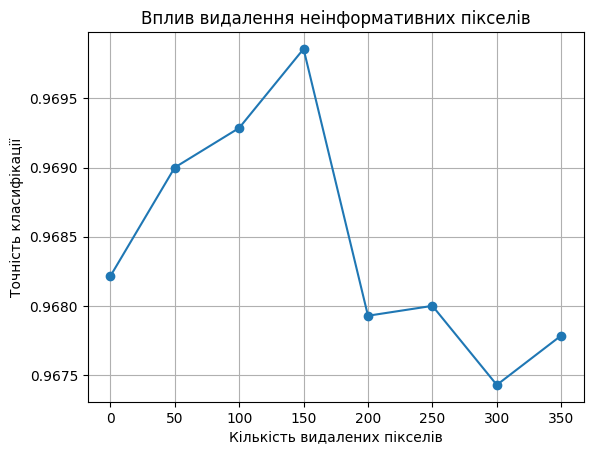

In [9]:
x_vals, y_vals = zip(*results)
plt.plot(x_vals, y_vals, marker='o')
plt.xlabel("Кількість видалених пікселів")
plt.ylabel("Точність класифікації")
plt.title("Вплив видалення неінформативних пікселів")
plt.grid(True)
plt.show()

In [11]:
best_removal = max(results, key=lambda x: x[1])
print(f"Найкраща точність: {best_removal[1]:.4f} при видаленні {best_removal[0]} пікселів")

Найкраща точність: 0.9699 при видаленні 150 пікселів


In [12]:
threshold = results[0][1] - 0.002
optimal = [r for r in results if r[1] >= threshold]
if optimal:
    print(f"Можна видалити до {optimal[-1][0]} пікселів без втрати точності (допуск 0.2%)")
else:
    print("Немає допустимого варіанту без втрати точності")

Можна видалити до 350 пікселів без втрати точності (допуск 0.2%)


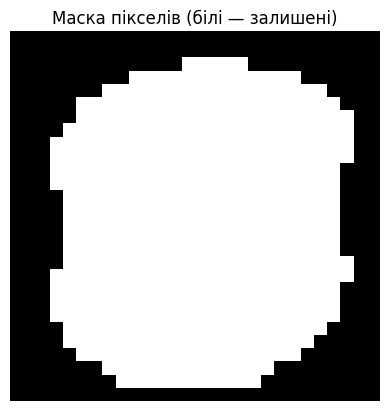

In [13]:
def visualize_mask(mask):
    plt.imshow(mask.reshape(28, 28), cmap="gray")
    plt.title("Маска пікселів (білі — залишені)")
    plt.axis("off")
    plt.show()

_, mask_last = apply_pixel_mask(X_train, sorted_indices, 300)
visualize_mask(mask_last.astype(int))